In [1]:
from pathlib import Path
ROOT_DIR = Path().resolve()

# 1. Load and investigate setup

This demo is based on the [WaterBench Southern North Sea](https://github.com/DHI/WaterBench-MIKE21HD-SouthernNorthSea) model and observations.

To load the data we leverage `MIKEIO` and its pfs reading capabilities

In [2]:
import mikeio

# specify simulation setup file 
simfile = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/sns_base.m21fm"
# read with mikeio and display some information
pfs = mikeio.read_pfs(simfile)
pfs.FemEngineHD.TIME

Touched = 1
start_time = 2022, 1, 1, 0, 0, 0
time_step_interval = 600.0
number_of_time_steps = 500

# 2. Run simulation with simple logging

* simplest version with basic logging of runtime information (from stdout, interpolation in tensorboard if output frequency is lower than logging frequency)
* without utilizing observations


* introducting `RunTimeEvaluation` (RTE). 
    * Evaluates and generates logs with `TensorBoards` SummaryWriter (default is a timestamped directory like logs/simulation_YYYYMMDD_HHMMSS)
    * Logs can be found in `/teamspace/studios/this_studio/logs` and accessed via Tensorboard in real time.
    * frequency is the only argument that can be used in the RTE when no observation (SimObsPairs) are specified.
    * Logs will solely contain runtime information   
* introducing simulation `Launcher`
* introducing Tensorboard

In [3]:
from mike_autocal.mikesimulation import RunTimeEvaluation, Launcher


rte = RunTimeEvaluation(frequency=50) # frequency of logging will be every 10 timesteps by default  

launcher = Launcher(
    simfile = simfile,      # path to simulation setup file
    use_gpu=True,           # use GPU if available
    runtimeevaluation=rte,  # Use an empty RunTimeEvaluation object
    n_cores = 1)
    
launcher.execute_simulation();

Processing: 100%|██████████| 500/500 [00:14<00:00, 34.90step/s]


# 2. Extend logging with error tracking from in-situ observations

* we need to link observations to simulation output
* introducing `SimObsPairs` 
* extended RTE allows for live tracking of specified error metrics

* <mark> can we track errors from different stations individually in tensorboard? if not should we add support for it?</mark>

In [4]:
from mike_autocal.dataio import ObservationData, SimObsPair, SimulationData

base_sim_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/sns_base.m21fm - Result Files"
base_obs_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/observations"

simobs = [
    SimObsPair(
        name="F3platform",
        pair_type="point",
        sim=SimulationData(
            file_path = base_sim_path / "waterlevels.dfs0",
            item=7,  
        ),
        obs=ObservationData(
            file_path = base_obs_path / "F3platform_wl.dfs0",
            item=0,  
        ),
    ),
    SimObsPair(
        name="Helgoland",
        pair_type="point",
        sim=SimulationData(
            file_path = base_sim_path / "waterlevels.dfs0",
            item=5,  
        ),
        obs=ObservationData(
            file_path = base_obs_path / "Helgoland_wl.dfs0",
            item=0,  
        ),
    ), # add as many as you want
    ]

using rte and the launcher once again, slightly extended.
* introducing `InnerMetric` as well as `OuterMetric`

In [5]:
from mike_autocal.objective_fun import RMSEInnerMetric, AMEANOuterMetric


# Step 2: Specify RunTimeEvaluation properties
rte = RunTimeEvaluation(simobs=simobs, 
                        inner_metric=[RMSEInnerMetric()], # can be multiple metrics as well (e.g. CC) 
                        outer_metric=[AMEANOuterMetric()], # defines how to aggregate data from multiple stations
                        frequency=50)


launcher = Launcher(
    simfile = simfile,      # path to simulation setup file
    use_gpu=True,           # use GPU if available
    runtimeevaluation=rte,  # Use new RunTimeEvaluation object
    n_cores = 1)
    
launcher.execute_simulation();

Processing: 100%|██████████| 500/500 [00:13<00:00, 35.86step/s]


# 

# 3. Automatic calibration guided by error metrics

* introducing optuna
* introducing measurement functions


<mark>how do we set number of random initial trials?</mark>

<Axes: title={'center': '2025-02-26 15:33:23'}, xlabel='Longitude [degrees]', ylabel='Latitude [degrees]'>

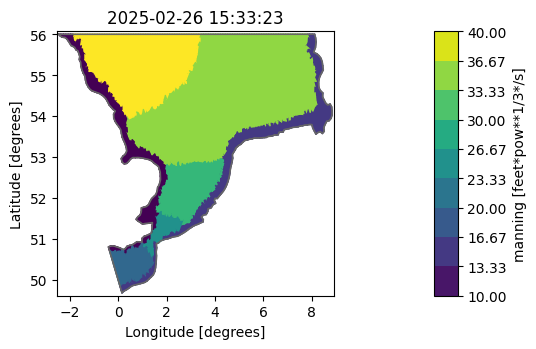

In [6]:
manningfile = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/conditions/ManningM.dfsu"
mikeio.read(manningfile)[0].plot()

In [7]:
#from datetime import datetime
import optuna

from mike_autocal.measurement_fun import ManningFile

sampler = optuna.samplers.GPSampler(seed=0) # which optimization algorithm to use (defaults to TPE)
evaluation_time = slice(50, None)           # at which time steps to evaluate the objective function (it can be a good idea to leave the swing-in period out)

inner_metric = [RMSEInnerMetric()] # can be multiple metrics as well (e.g. CC) 
outer_metric = [AMEANOuterMetric()] # defines how to aggregate data from multiple stations

direction = ["minimize"]                    # direction of optimization (see inner metric), can be multiobjective 
n_trials = 11                               # number of simulation runs in optimization
study_name = "testing_calibration"          # recognizable name


measurement_functions = [
    ManningFile(
        filename= manningfile,
        item_name="manning",
        low=0.001,
        high=81.101,
        step=0.01,
    )]

/tmp/ipykernel_31785/1808492885.py:6: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler = optuna.samplers.GPSampler(seed=0) # which optimization algorithm to use (defaults to TPE)


<mark>calibration. RTE not reused here with inner and outer metric and frequency. Instead separate autocal. Does this make sense or should we be more consistent? </mark>

In [9]:
from mike_autocal.autocal import AutoCal


calibration = AutoCal(
    launcher=launcher,          # already contains simfile
    # add observations and metrics
    simobs=simobs,
    inner_metric=inner_metric,  
    outer_metric=outer_metric,
    # optimization settings
    study_name=study_name,
    n_trials=n_trials,
    direction=direction,
    sampler=sampler, 
    measurement_functions=measurement_functions,
    evaluation_time=evaluation_time,
    verbose=False,
    load_if_exists=False,
)
calibration.run()

[I 2025-05-15 12:58:23,676] A new study created in Journal with name: testing_calibration
INFO:autocal:------------------------------------ Trial: 0 ------------------------------------
Processing: 100%|██████████| 500/500 [00:14<00:00, 34.19step/s]
INFO:autocal:InnerEvaluation(metric=RMSE):
              values    n
name                     
F3platform  0.309701  451
Helgoland   1.264383  451
[I 2025-05-15 12:58:39,191] Trial 0 finished with value: 0.7870422079758148 and parameters: {'Manning_0': 44.510999999999996, 'Manning_1': 58.001, 'Manning_2': 48.891, 'Manning_3': 44.190999999999995, 'Manning_4': 34.361, 'Manning_5': 52.381, 'Manning_6': 35.491}. Best is trial 0 with value: 0.7870422079758148.
INFO:autocal:------------------------------------ Trial: 1 ------------------------------------
Processing: 100%|██████████| 500/500 [00:14<00:00, 34.92step/s]
INFO:autocal:InnerEvaluation(metric=RMSE):
              values    n
name                     
F3platform  0.309006  451
Helgoland